# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('./data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

c:\program files\python3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [5]:
set(azdias.columns)-set(customers.columns)

set()

In [6]:
set(customers.columns)-set(azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

The customers table has three more fields.

In [7]:
DIAS_attributes= pd.read_excel("DIAS Attributes - Values 2017.xlsx")

In [8]:
DIAS_attributes.shape

(2258, 5)

In [9]:
 DIAS_info=pd.read_excel("DIAS Information Levels - Attributes 2017.xlsx")

In [10]:
# Mark nan from the azdias data
DIAS_attributes.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [11]:
DIAS_attributes.drop(['Unnamed: 0'],axis=1,inplace=True)

In [12]:
if 'Attribute' in DIAS_attributes.iloc[0][0]:
    DIAS_attributes.drop(index=[0],axis=0,inplace=True)

In [13]:
DIAS_attributes.columns = ['Attribute','Description','Value','Meaning']

In [14]:
attribute_name=''
for i,v in DIAS_attributes.iterrows():
    if v['Attribute'] is np.nan:
        v['Attribute']=attribute_name
    else:
        attribute_name=v['Attribute']

In [15]:
missing_attribute_value_list=[]
for i,v in DIAS_attributes.iterrows():
    if v['Meaning'] is not np.nan:
        if 'unknown' in v['Meaning']:
            missing_attribute_value_list.append([v['Attribute'],v['Value'],v['Meaning']])

In [16]:
def unknown2missing(df):
    for l in missing_attribute_value_list:
        if l[0] in df.columns:
            if isinstance(l[1],int):
                df[l[0]].replace(l[1],np.nan,inplace=True)
            else:
                for ll in l[1].split(','):
                    df[l[0]].replace(int(ll),np.nan,inplace=True)
    return df
        

In [17]:
print(azdias.isnull().mean().mean())
azdias=unknown2missing(azdias)
print(azdias.isnull().mean().mean())

0.10268016415595567
0.11370020865890973


In [18]:
print(customers.isnull().mean().mean())
customers=unknown2missing(customers)
print(customers.isnull().mean().mean())

0.1960492473457283
0.20487207872308308


# Clean The Data

## 1.process the missing features

In [19]:
# deal with columns
azdias_col_null=(azdias.isnull().sum()/len(azdias)).sort_values(ascending=False)
customers_col_null=(customers.isnull().sum()/len(customers)).sort_values(ascending=False)

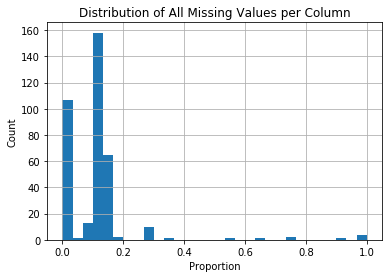

In [20]:
azdias_col_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');

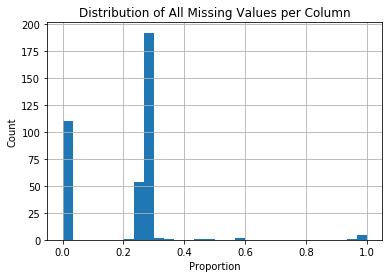

In [21]:
customers_col_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');

In [22]:
#remove the features that has over 30% missing rate
remove_features=set(azdias_col_null[azdias_col_null>0.3].index)|set(customers_col_null[customers_col_null>0.3].index)
print(remove_features)
azdias.drop(labels=remove_features,axis=1,inplace=True)
customers.drop(labels=remove_features,axis=1,inplace=True)
print(azdias.shape,customers.shape)

{'KBA05_BAUMAX', 'AGER_TYP', 'ALTER_KIND4', 'ALTER_KIND3', 'KK_KUNDENTYP', 'TITEL_KZ', 'ALTER_KIND2', 'ALTER_KIND1', 'ALTER_HH', 'KKK', 'EXTSEL992', 'REGIOTYP'}
(891221, 354) (191652, 357)


In [23]:
# deal with rows
azdias_row_null=(azdias.isnull().mean(axis=1)).sort_values(ascending=False)
customers_row_null=(customers.isnull().mean(axis=1)).sort_values(ascending=False)

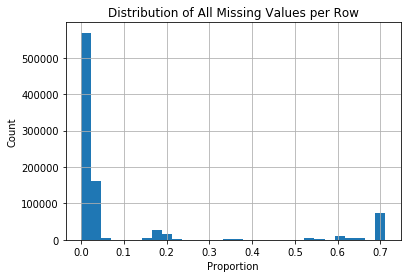

In [24]:
azdias_row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');

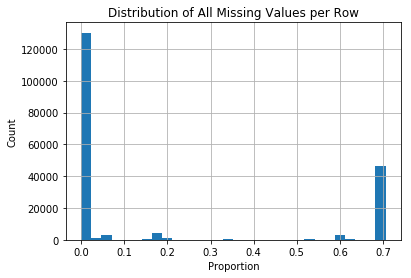

In [25]:
customers_row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');

In [26]:
print(azdias.shape,customers.shape)

(891221, 354) (191652, 357)


In [27]:
#remove the row that has over 10% missing rate
azdias_remove_row=azdias_row_null[azdias_row_null>0.1].index
customers_remove_row=customers_row_null[customers_row_null>0.1].index

azdias.drop(index=azdias_remove_row,axis=0,inplace=True)
customers.drop(index=customers_remove_row,axis=0,inplace=True)

In [28]:
print(azdias.shape,customers.shape)

(737215, 354) (134245, 357)


In [29]:
print(azdias.isnull().mean().mean())
print(customers.isnull().mean().mean())

0.007873359545128826
0.002314823653771539


In [30]:
print(azdias.info(),customers.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737215 entries, 1 to 891220
Columns: 354 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(261), int64(87), object(6)
memory usage: 1.9+ GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 134245 entries, 0 to 191651
Columns: 357 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(261), int64(88), object(8)
memory usage: 366.7+ MB
None None


In [31]:
# fill the missing data with mode

In [32]:
len(azdias.isnull().any()[azdias.isnull().any()==True].index)

69

In [33]:
fillna_cols=azdias.isnull().any()[azdias.isnull().any()==True].index.tolist()

In [34]:
type(fillna_cols)

list

In [35]:
for l in fillna_cols:
    azdias[l]=azdias[l].fillna(value=azdias[l].mode().iloc[0])

In [36]:
len(azdias.isnull().any()[azdias.isnull().any()==True].index)

0

In [37]:
def nan2mode(df):
    fillna_cols=df.isnull().any()[df.isnull().any()==True].index.tolist()
    for l in fillna_cols:
        df[l]=df[l].fillna(value=df[l].mode().iloc[0])
    return df

In [38]:
customers=nan2mode(customers)
len(customers.isnull().any()[customers.isnull().any()==True].index)

0

In [39]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737215 entries, 1 to 891220
Columns: 354 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(261), int64(87), object(6)
memory usage: 1.9+ GB


In [40]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134245 entries, 0 to 191651
Columns: 357 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(261), int64(88), object(8)
memory usage: 366.7+ MB


## 2.Drop some features

In [47]:
drop_features=[]
azdias.columns.to_series().groupby(azdias.dtypes).groups

{dtype('int64'): Index(['LNR', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
        'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
        'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
        'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
        'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
        'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
        'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
        'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK',
        'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX',
        'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_NAHRUNGSERGAENZUNG',
        'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
        'D19_SONSTIGE', 'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
        'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM',
        'D19_TELKO_ONLINE_DATUM', 'D19_TELK

In [48]:
# check the object datatype
azdias.select_dtypes(include=['object'])

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W
6,4A,4,22,D19_UNBEKANNT,1992-02-12 00:00:00,W
7,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W
8,1A,1,13,D19_UNBEKANNT,1992-02-10 00:00:00,W
9,1E,1,15,D19_KOSMETIK,1992-02-10 00:00:00,W
10,9D,9,51,D19_UNBEKANNT,1992-02-10 00:00:00,W


In [49]:
azdias['EINGEFUEGT_AM'].value_counts()

1992-02-10 00:00:00    372210
1992-02-12 00:00:00    187330
1995-02-07 00:00:00     10861
2003-11-18 00:00:00      5877
1993-03-01 00:00:00      3059
2005-04-15 00:00:00      2267
2000-05-10 00:00:00      2262
2004-04-14 00:00:00      2223
1992-02-21 00:00:00      1997
1994-02-03 00:00:00      1969
1995-10-17 00:00:00      1943
1995-10-10 00:00:00      1791
1993-09-21 00:00:00      1783
1993-09-22 00:00:00      1457
1993-04-01 00:00:00      1280
1993-04-02 00:00:00      1257
1994-12-13 00:00:00      1135
1995-10-18 00:00:00      1088
1995-07-19 00:00:00      1087
2005-04-12 00:00:00      1080
1996-03-07 00:00:00      1075
2003-11-17 00:00:00      1038
1993-10-21 00:00:00      1024
1996-05-09 00:00:00       988
1993-09-23 00:00:00       978
1995-08-15 00:00:00       957
1995-08-02 00:00:00       935
1994-02-10 00:00:00       887
1993-03-23 00:00:00       860
1995-09-06 00:00:00       854
                        ...  
1999-09-24 00:00:00         1
2001-09-04 00:00:00         1
1999-09-10

In [70]:
# I think the EINGEFUEGT_AM has nothing effect.
# I don't know meaning of 'D19_LETZTER_KAUF_BRANCHE' 
drop_features.append(['EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE'])

In [71]:
azdias['CAMEO_DEUG_2015'].value_counts()

8    131901
6    100680
9     99439
4     95580
2     76606
3     76314
7     72473
5     49708
1     34514
Name: CAMEO_DEUG_2015, dtype: int64

In [72]:
# CAMEO_DEU_2015,CAMEO_INTL_2015 include more detail than CAMEO_DEUG_2015
print(azdias['CAMEO_DEU_2015'].value_counts())
print(azdias['CAMEO_INTL_2015'].value_counts())

6B    57054
8A    50767
4C    43987
2D    32903
7A    32625
3C    32562
3D    32173
8B    31261
4A    30254
8C    30145
9D    26742
9B    25885
9C    22918
7B    22917
9A    20053
2C    17741
8D    16673
6E    15597
5D    14068
2B    14041
6C    13866
2A    11921
1D    11456
1A    10165
5A     9720
5B     9690
5C     9050
4B     8283
7C     8127
4D     8051
6A     6414
3A     5870
6D     5756
3B     5709
6F     5048
4E     5005
1E     4782
7D     4430
7E     4374
1C     4012
5F     3939
9E     3841
1B     3815
5E     3241
XX      284
Name: CAMEO_DEU_2015, dtype: int64
51      76306
51.0    53061
41      50256
24      49089
41.0    36547
24.0    35511
14      33993
43      31167
54      24640
14.0    24478
43.0    22832
25      21389
54.0    18062
22      17423
25.0    15789
45      14547
13      14002
22.0    12831
55      11814
23      11574
52      11560
45.0    10472
13.0    10204
34      10026
15       9387
31       9328
55.0     8700
52.0     8493
23.0     8288
44       7980
34.0 

In [73]:
# I will drop CAMEO_DEU_2015 and CAMEO_INTL_2015 ,I will dorp the 'X' value of the CAMEO_DEUG_2015
drop_features.append(['CAMEO_DEU_2015','CAMEO_INTL_2015'])
azdias['CAMEO_DEUG_2015'].replace('X',1,inplace=True)

In [74]:
azdias['CAMEO_DEUG_2015']=azdias['CAMEO_DEUG_2015'].astype('int')

In [75]:
azdias['CAMEO_DEUG_2015'].value_counts()

8    131901
6    100680
9     99439
4     95580
2     76606
3     76314
7     72473
5     49708
1     34514
Name: CAMEO_DEUG_2015, dtype: int64

In [76]:
# transform object type to int
# azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']]
# = 
CAMEO_list=[]
for l in azdias.columns.tolist():
    if 'CAMEO' in l:
        CAMEO_list.append(l)
print(CAMEO_list)

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']


In [44]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [45]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

FileNotFoundError: File b'../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv' does not exist

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')